# Sound recognition using Tensorflow

Following the _Simple Audio_ example [here](https://www.tensorflow.org/tutorials/audio/simple_audio).

We'll be using **`tf.keras.utils.audio_dataset_from_directory`** to generate audio classification datasets from directories of **.wav** files.
We'll also use [seaborn](https://seaborn.pydata.org/) to plot the audio spectrum.

In [3]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# The newer Wrapt extension is incompatible with Tensorflow
# and may raise the error "TypeError: this __dict__ descriptor does not support '_DictWrapper' objects"
# when trying to save the model.
# Disable it for now.
os.environ['WRAPT_DISABLE_EXTENSIONS'] = 'true'
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2025-09-16 11:00:24.627637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757984424.640195   24410 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757984424.644709   24410 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Download the mini version of the Speech Commands dataset. The mini version contains 8,000 files of people saying 8 words. The original version contains 105,000 audio files of 35 words.

In [4]:
#DATASET_PATH =  'data/mini_speech_commands_extracted/mini_speech_commands/'
DATASET_PATH =  'data/speech_commands_v0_extracted/'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
#      fname='mini_speech_commands.zip',
      fname='speech_commands_v0.02.tar.gz',
#      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      origin="http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz",
      extract=True,
      cache_dir='.', cache_subdir='data')

The dataset's audio clips are stored in folders corresponding to the speech command: **`go`**, **`two`**, etc.

In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
exclude_filenames = ['README.md', '.DS_Store', '_background_noise_', 'LICENSE', 'testing_list.txt', 'validation_list.txt']
commands = commands[np.isin(commands, exclude_filenames, invert=True)]
print(f'{len(commands)} {commands=}')

35 commands=array(['go', 'two', 'bed', 'learn', 'house', 'seven', 'tree', 'sheila',
       'five', 'no', 'one', 'happy', 'marvin', 'cat', 'four', 'zero',
       'nine', 'forward', 'down', 'follow', 'up', 'six', 'wow', 'stop',
       'on', 'dog', 'off', 'backward', 'visual', 'three', 'eight',
       'right', 'bird', 'left', 'yes'], dtype='<U19')


Divided into directories this way, we can easily load the data using **`keras.utils.audio_dataset_from_directory`**.

The audio clips are 1 second or less at 16kHz. The **`output_sequence_length=16000`** pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [6]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 105835 files belonging to 36 classes.
Using 84668 files for training.
Using 21167 files for validation.


I0000 00:00:1757984429.090834   24410 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14323 MB memory:  -> device: 0, name: Quadro RTX 5000 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5



label names: ['_background_noise_' 'backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight'
 'five' 'follow' 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left'
 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six'
 'stop' 'three' 'tree' 'two' 'up' 'visual' 'wow' 'yes' 'zero']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of **`(batch, samples, channels)`**.

In [7]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the **`tf.squeeze`** function to drop the extra axis:

In [8]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The **`utils.audio_dataset_from_directory`** function only returns up to two splits: `train_ds` and `val_ds`. It's a good idea to keep a test set separate from the validation set. Ideally, we'd keep it in a separate directory, but in this case we can use **`Dataset.shard`** to split the validation setinto two halves. Note that iterating over any shard will load **all** the data, and only keep its fraction.

In [9]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [10]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


2025-09-16 11:00:30.205105: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Let's plot a few audio waveforms:

In [11]:
label_names[[1,1,3,0]]

array(['backward', 'backward', 'bird', '_background_noise_'], dtype='<U18')

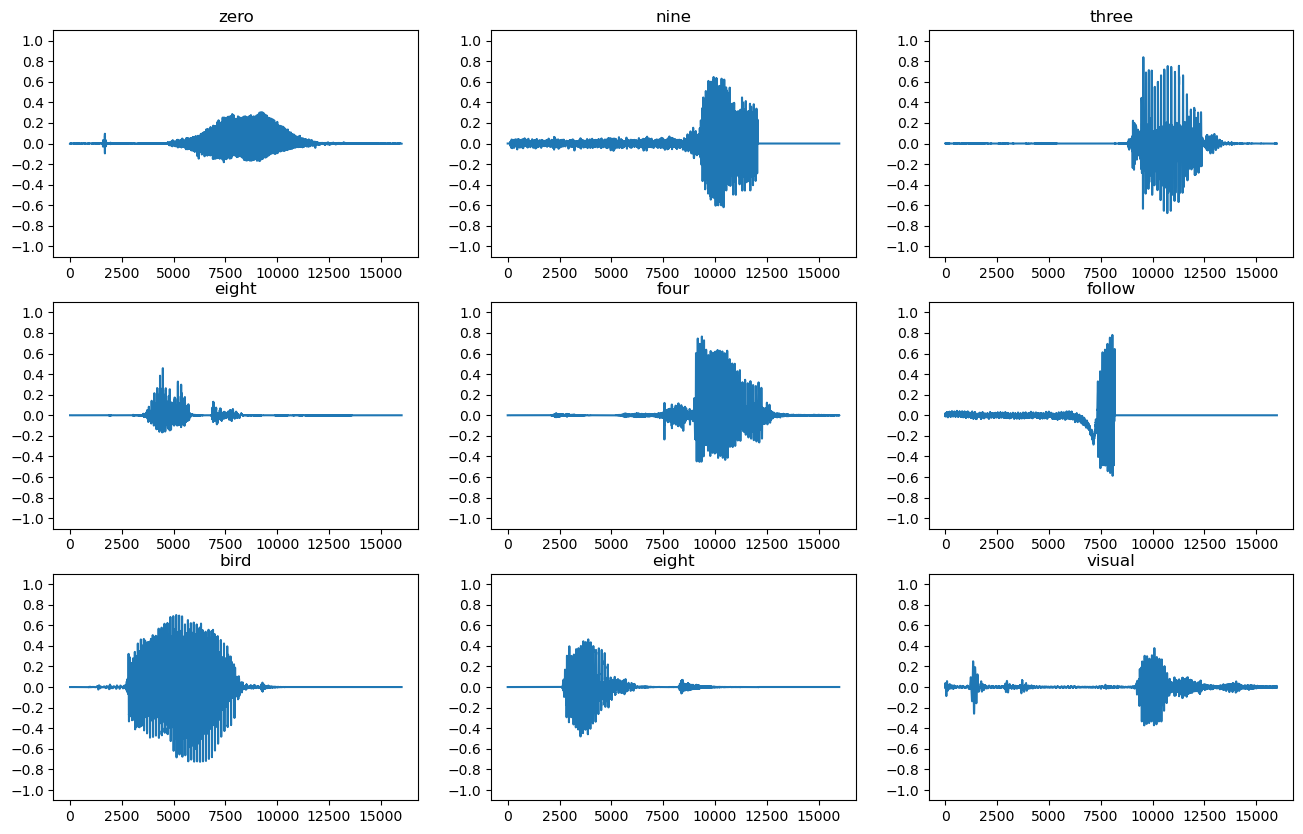

In [12]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The above graphs show the waveforms in the time domain, i.e. the `y`-axis depicts the air pressure as time varies on the `x`-axis. This is not enough to distinguish some sounds. We'll need to transform them into the time-and-frequency-domain signals, whose graphs are called spectrograms, by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform). These are 2D maps (or tensors) depicting signal's the frequency and phase as time varies.

A Fourier transform ([`tf.signal.fft`](https://www.tensorflow.org/api_docs/python/tf/signal/fft)) converts a signal's time-domain component to its frequency-domain component (wave amplitudes as time varies), but loses all time information. In comparison, STFT ([`tf.signal.stft`](https://www.tensorflow.org/api_docs/python/tf/signal/stft)) splits the signal into short time windows and runs a Fourier transform on each window, thus preserving some time information, and returning a 2D tensor that we can run standard convolutions on.

First, we create a utility function to convert waveforms to spectrograms:
- The waveforms need to be of the same length, so that when we convert them to spectrograms, the results have similar dimensions. We have done this when extracting `train_ds` and `val_ds` by specifying **`output_sequence_length=16000`**.
- When calling [`tf.signal.stft`](https://www.tensorflow.org/api_docs/python/tf/signal/stft), choose **`frame_length`** and **`frame_step`** parameters such that the generated spectrogram 2D tensor is almost square. Refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT for more information.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this notebook we'll only use the magnitude, which we can derive by applying [`tf.abs`](https://www.tensorflow.org/api_docs/python/tf/math/abs) on the output of [`tf.signal.stft`](https://www.tensorflow.org/api_docs/python/tf/signal/stft).

In [13]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [14]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: zero
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: nine
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: three
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Create a utility function to display a spectrogram:

In [15]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

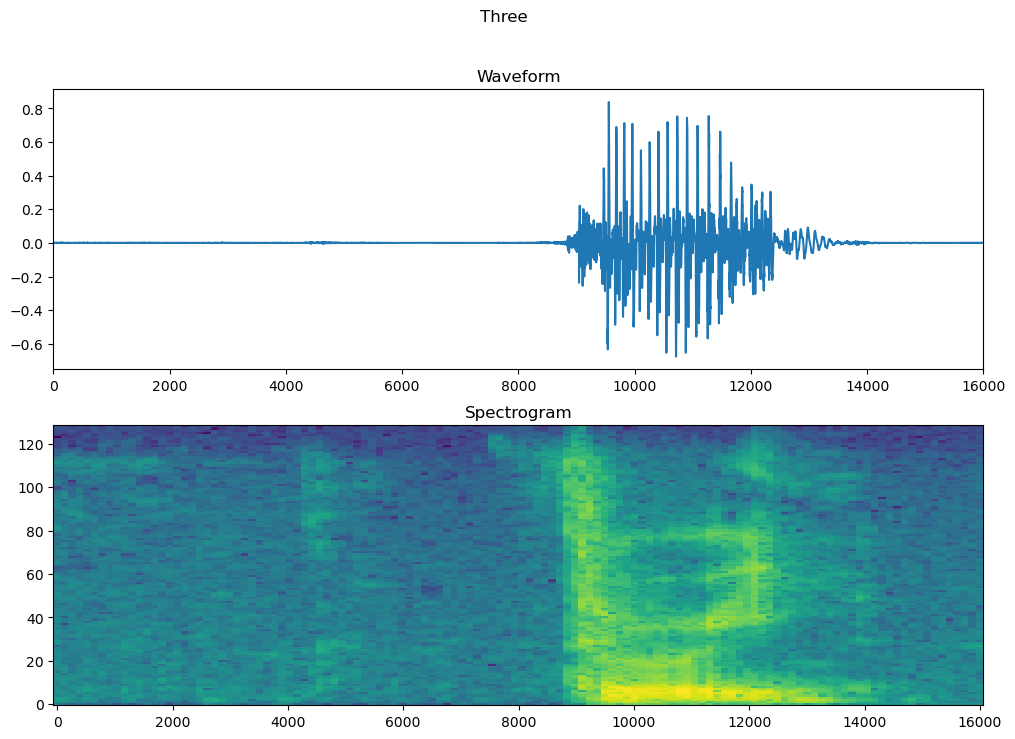

In [16]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create the spectrogram datasets from the audio datasets:

In [17]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [18]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [19]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

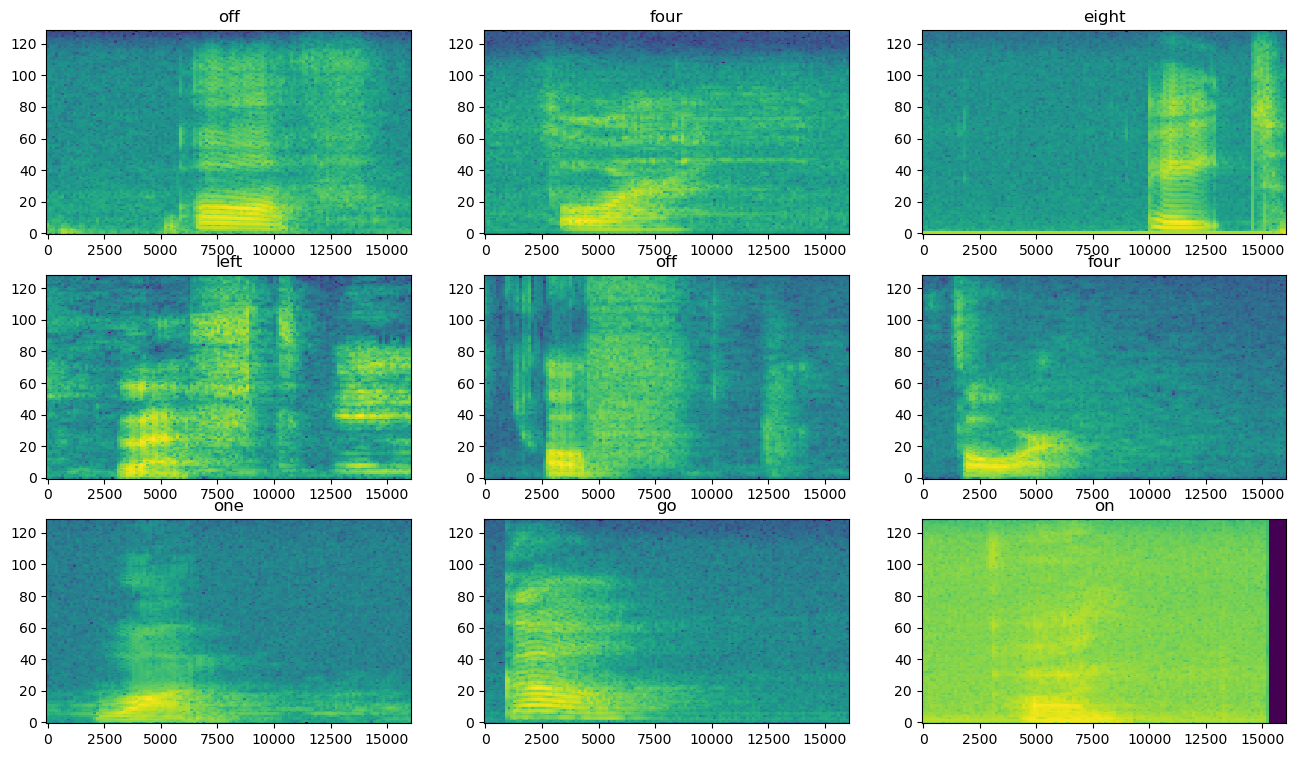

In [20]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

Add [**`Dataset.cache`**](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) and [**`Dataset.prefetch`**](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) operations to reduce read latency while training the model:

In [21]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

We'll use a simple convolutional neural network (CNN), since we have transformed the audio files into spectrogram images.

Our [**`tf.keras.Sequential`**](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model will use the following Keras preprocessing layers:
- [**`tf.keras.layers.Resizing`**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing): to downsample the input to enable the model to train faster.
- [**`tf.keras.layers.Normalization`**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization): to normalize each pixel in the image based on its mean and standard deviation.

For the **`Normalization`** layer, its **`adapt`** method would first need to be called on the training data in order to compute aggregate statistics such as the mean and the standard deviation.

In [22]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


2025-09-16 16:27:10.295964: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,629,223 (6.21 MB)

 Trainable params: 1,629,220 (6.21 MB)

 Non-trainable params: 3 (16.00 B)

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 20 epochs:

In [24]:
EPOCHS = 20
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20


I0000 00:00:1758004173.868649  103982 service.cc:148] XLA service 0x7f3908004240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758004173.868668  103982 service.cc:156]   StreamExecutor device (0): Quadro RTX 5000 with Max-Q Design, Compute Capability 7.5
2025-09-16 16:29:33.900863: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1758004174.013179  103982 cuda_dnn.cc:529] Loaded cuDNN version 91300
2025-09-16 16:29:34.310465: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[64,32,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,1,32,32]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config"

  39/1323 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.0438 - loss: 3.5815

I0000 00:00:1758004175.832041  103982 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 589/1323 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1749 - loss: 3.0281

2025-09-16 16:29:38.366386: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[60,32,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[60,1,32,32]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-09-16 16:29:38.378026: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[60,64,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[60,32,30,30]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config=

1311/1323 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2723 - loss: 2.6313

2025-09-16 16:29:42.879202: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[64,32,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,1,32,32]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-09-16 16:29:42.892374: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[64,64,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,30,30]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config=

1323/1323 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.4102 - loss: 2.0789 - val_accuracy: 0.6978 - val_loss: 1.0861
Epoch 2/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6228 - loss: 1.2808 - val_accuracy: 0.7515 - val_loss: 0.8701
Epoch 3/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6791 - loss: 1.0799 - val_accuracy: 0.7907 - val_loss: 0.7466
Epoch 4/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7149 - loss: 0.9567 - val_accuracy: 0.8079 - val_loss: 0.6774
Epoch 5/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7378 - loss: 0.8720 - val_accuracy: 0.8183 - val_loss: 0.6295
Epoch 6/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7530 - loss: 0.8160 - val_accuracy: 0.8199 - val_loss: 0.6297
Epoch 7/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7647 - loss: 0.7648 - val_accuracy: 0.8247 - val_loss: 0.6095
Epoch 8/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7781 - loss: 0.7200 - val_accura

Let's plot the training and validation loss curves to check how the model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

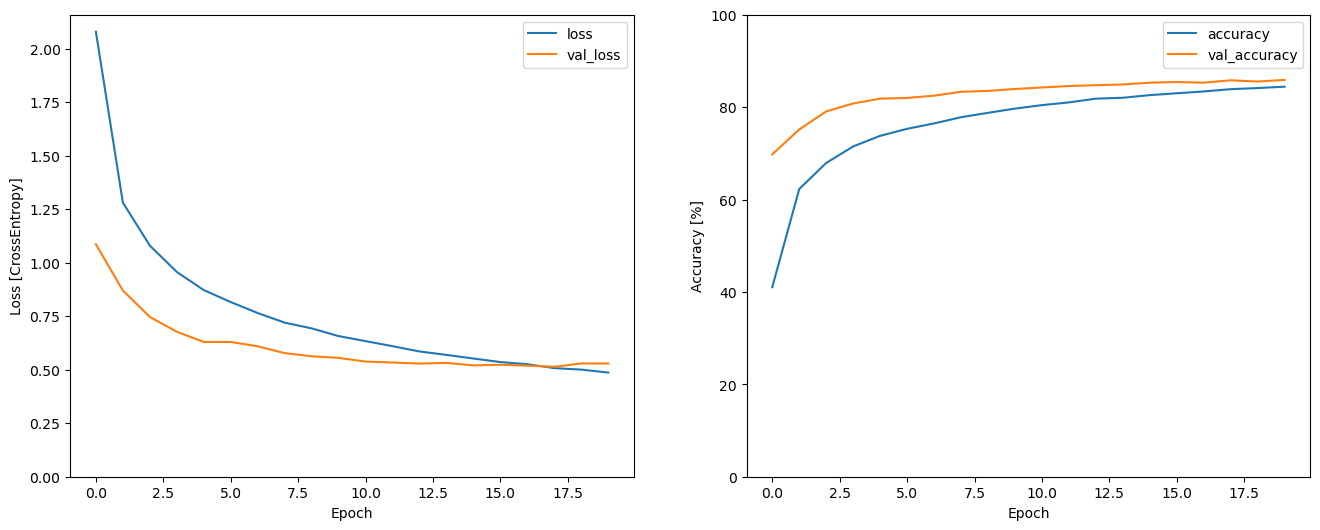

In [25]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [26]:
model.evaluate(test_spectrogram_ds, return_dict=True)

152/166 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8645 - loss: 0.4927

2025-09-16 16:33:37.338433: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[47,32,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[47,1,32,32]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-09-16 16:33:37.346741: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[47,64,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[47,32,30,30]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config=

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8656 - loss: 0.4894


{'accuracy': 0.8655604720115662, 'loss': 0.4893936514854431}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:

In [27]:
y_pred = model.predict(test_spectrogram_ds)

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [28]:
y_pred = tf.argmax(y_pred, axis=1)

In [29]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

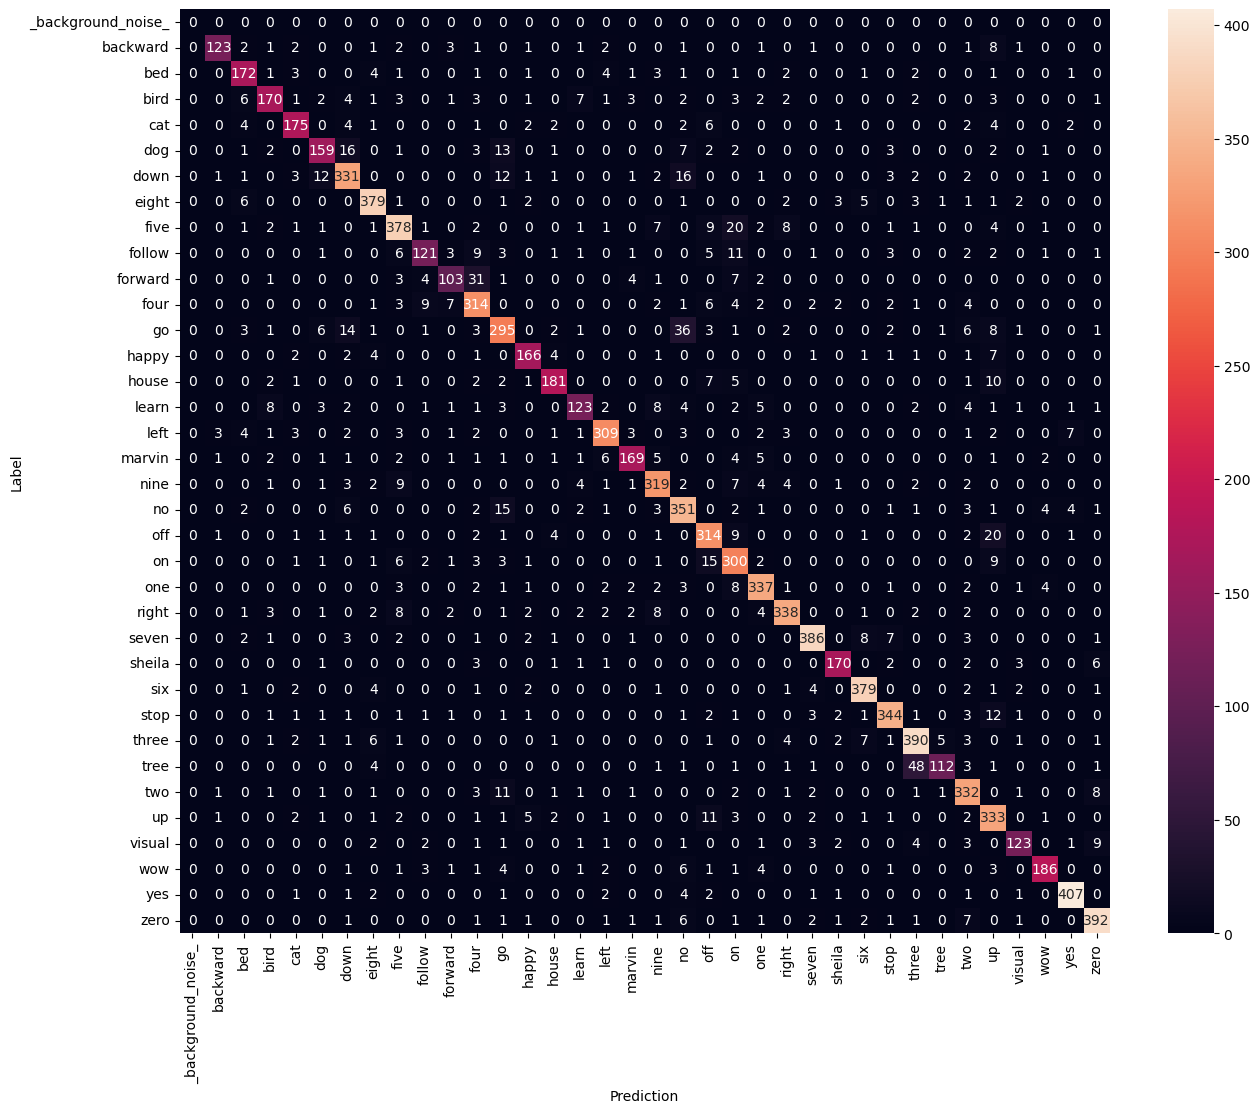

In [34]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15, 12))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does our model perform?

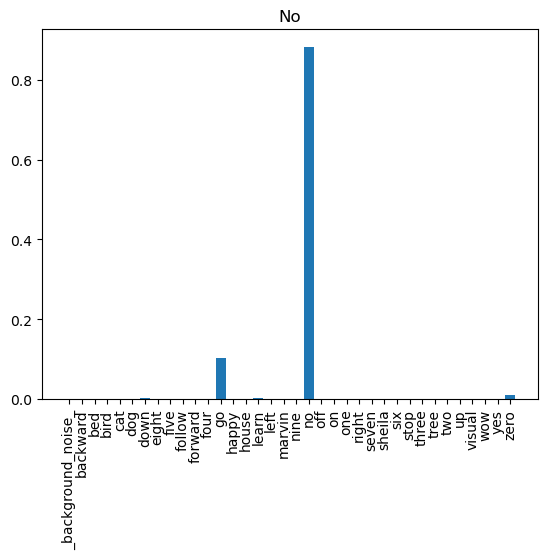

In [38]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
#x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
x_labels = ['_background_noise_', 'backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight',
 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left',
 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six',
 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.xticks(rotation=90)
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

As the output suggests, our model would recognize the audio command as "no".

## Export the model with preprocessing

The model's not very easy to use if we have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [40]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # You could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)  
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [41]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 36), dtype=float32, numpy=
 array([[-45.894047 ,  -9.856797 ,  -6.824177 ,  -8.38823  , -11.9155   ,
          -1.4705544,   1.5666928, -12.210831 , -14.759647 ,  -6.138623 ,
          -9.603647 ,  -5.979495 ,   5.213118 , -14.458386 ,  -9.055349 ,
           1.5756612,  -8.252783 ,  -6.412923 ,  -2.9711297,   7.3602934,
         -16.770107 , -14.583654 ,  -8.728846 , -11.033661 ,  -9.458457 ,
          -4.3749733, -14.687572 ,  -6.4855776,  -9.875031 , -13.442843 ,
          -3.421771 , -13.791344 ,  -1.0453861,  -2.0323946,  -4.026824 ,
           2.767708 ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([19])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [42]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets


{'predictions': <tf.Tensor: shape=(1, 36), dtype=float32, numpy=
 array([[-45.894047 ,  -9.856797 ,  -6.824177 ,  -8.38823  , -11.9155   ,
          -1.4705544,   1.5666928, -12.210831 , -14.759647 ,  -6.138623 ,
          -9.603647 ,  -5.979495 ,   5.213118 , -14.458386 ,  -9.055349 ,
           1.5756612,  -8.252783 ,  -6.412923 ,  -2.9711297,   7.3602934,
         -16.770107 , -14.583654 ,  -8.728846 , -11.033661 ,  -9.458457 ,
          -4.3749733, -14.687572 ,  -6.4855776,  -9.875031 , -13.442843 ,
          -3.421771 , -13.791344 ,  -1.0453861,  -2.0323946,  -4.026824 ,
           2.767708 ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([19])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}